1. Dataset Class (CustomMNISTDataset)
	•	Reasoning:
	•	We need to create a custom dataset class to load the MNIST data from a CSV file. MNIST is typically a collection of image files, but in this case, the data is stored in a CSV format where each row represents an image (flattened pixels) and its label.
	•	The dataset must handle both training and test data (test data does not have labels, so we need to account for that).
	•	Improvements:
	•	You could add more sophisticated data augmentation techniques to improve the model’s robustness, such as random rotations, flips, etc.

2. Data Transforms (data_transforms)
	•	Reasoning:
	•	The ToTensor() transform converts image data into a PyTorch tensor, which is required for input to the neural network.
	•	The Normalize() transform standardizes the input data to have a mean of 0.5 and a standard deviation of 0.5, which is common for MNIST to make training more stable.
	•	Improvements:
	•	If you’re working with a more complex dataset, you could also include other augmentations such as random cropping, flipping, etc., to artificially increase the diversity of the dataset.

3. DataLoader
	•	Reasoning:
	•	The DataLoader efficiently loads the dataset in batches, making training and inference faster by utilizing multiple worker threads for data loading.
	•	The shuffle=False is used for the test set since we don’t need to shuffle the data when making predictions.
	•	Improvements:
	•	For validation data, you may want to use shuffle=True during training to prevent the model from overfitting on the sequential order of data.

4. Model Architecture (SimpleCNN)
	•	Reasoning:
	•	The model uses Convolutional Neural Networks (CNNs) because CNNs are highly effective for image classification tasks.
	•	The model starts with 3 convolutional layers followed by ReLU activations and max pooling, which reduces spatial dimensions and extracts important features.
	•	Finally, fully connected layers are used to classify the image into one of the 10 categories (digits 0-9).
	•	Improvements:
	•	Adding more layers or experimenting with different architectures like ResNet or VGG could improve performance if needed.

5. Device Setup (GPU/CPU)
	•	Reasoning:
	•	The code automatically selects a GPU if one is available. Using a GPU speeds up training and inference, especially for deep neural networks.
	•	Improvements:
	•	If you’re working in a multi-GPU environment, you could use DataParallel or DistributedDataParallel for scaling.

6. Model Inference
	•	Reasoning:
	•	During evaluation (model.eval()), dropout and batch normalization are disabled, ensuring the model’s performance is not affected by randomness.
	•	The model makes predictions using the test data, and the results are stored in the predictions list.
	•	Improvements:
	•	For further optimization, you could perform inference using batching on a GPU, which will speed up the process.

7. Submission Preparation
	•	Reasoning:
	•	The predictions are converted into a DataFrame to create the required format for Kaggle submissions.
	•	Improvements:
	•	You could add more metadata to the submission, such as confidence scores for each prediction.

8. Saving Predictions
	•	Reasoning:
	•	The predictions are saved as a CSV file using to_csv(), which is the format required for Kaggle submissions.

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [75]:
# Define CustomMNISTDataset
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]
        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]

        image = transforms.ToPILImage()(image)
        if self.transform is not None:
            image = self.transform(image)
        if self.is_test:
            return image  # Only the image for test set
        else:
            return image, label

In [76]:
# Define transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor (C, H, W)
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

In [77]:
# Create dataset and DataLoader
train_dataset = CustomMNISTDataset("/kaggle/input/digit-recognizer/train.csv", transform=data_transforms, is_test=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Input Size: torch.Size([64, 1, 28, 28])


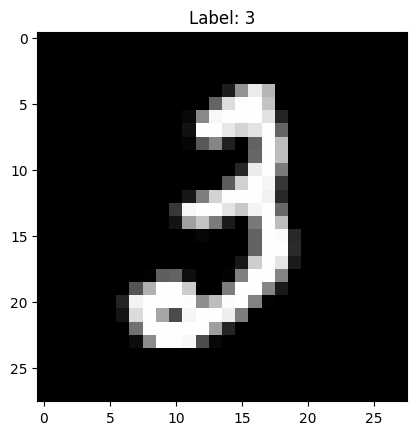

In [78]:
# Visualize a single batch
for example_data, example_labels in train_loader:
    print("Input Size:", example_data.size())  # Debugging size of input
    example_image = example_data[0]  # Take the first image in the batch
    example_image_numpy = example_image.permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)
    
    # Plot the image
    plt.imshow(example_image_numpy.squeeze(), cmap="gray")  # Squeeze to remove empty channel
    plt.title(f"Label: {example_labels[0].item()}")  # Get the label of the first image
    plt.show()
    break

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Dynamically determine the size of the flattened input
        self.flatten_size = 128 * 3 * 3  # Correct size after pooling for MNIST images (28x28)
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)  # Final shape (batch_size, 128, 3, 3) for MNIST (28x28)

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten dynamically using batch size
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [80]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
num_epochs = 100

running_loss = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i +1}] Loss : {running_loss / 100: .3f}")
            running_loss = 0.0


print("Training Finished")


[1, 100] Loss :  0.001
[1, 200] Loss :  0.001
[1, 300] Loss :  0.001
[1, 400] Loss :  0.001


In [ ]:
# Test Dataset and DataLoader
test_dataset = CustomMNISTDataset(
    "/kaggle/input/digit-recognizer/test.csv",
    transform=data_transforms,
    is_test=True
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model evaluation and prediction
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:  # Test dataset only returns `data`
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        predictions.extend(predicted.cpu().tolist())

# Creating the submission DataFrame
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),
    "Label": predictions
})

# Save the predictions to a CSV file
submission.to_csv('predictions_final.csv', index=False)
print("Submission file created: predictions_final.csv")